# 02 — Spectral & Correlation Analysis

This notebook covers frequency-domain and lag-domain characterization of time series.

## Topics
- **Power Spectral Density (PSD)**: Welch method, custom implementations
- **Autocorrelation Function (ACF)**: Lag-correlation structure
- **Hilbert Transform & Envelope**: Amplitude modulation analysis
- **AM vs Nearby Modes**: Same spectrum, different dynamics
- **IAAFT Surrogates**: Preserving spectrum while destroying phase
- **Bicoherence**: Higher-order spectral analysis

---

**Sources**: 
- [1overf_sim.ipynb](../1overf_sim.ipynb)
- [AdvatnagToSpectralMethod.ipynb](../AdvatnagToSpectralMethod.ipynb)
- [MiceData.ipynb](../MiceData.ipynb)

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt

# Reproducibility
rng = np.random.default_rng(42)

---

## 1. Signal Generators (for demonstrations)

Functions to generate test signals: white noise, 1/f (pink) noise, and colored noise.

**Sources**: [1overf_sim.ipynb](../1overf_sim.ipynb), [AdvatnagToSpectralMethod.ipynb](../AdvatnagToSpectralMethod.ipynb)

In [2]:
# =============================================================================
# Signal Generators
# =============================================================================

# Variant 1: White noise
# Source: 1overf_sim.ipynb
def make_white_noise(n, seed=None):
    """Generate white (Gaussian) noise."""
    rng = np.random.default_rng(seed)
    return rng.standard_normal(n)


# Variant 2: 1/f^α (colored) noise via spectral shaping
# Source: 1overf_sim.ipynb
def make_1_over_f_noise(n, fs=1.0, alpha=1.0, seed=None):
    """
    Generate 1/f^α (pink/colored) noise via spectral shaping.
    
    Parameters
    ----------
    n : int
        Number of samples.
    fs : float
        Sampling frequency.
    alpha : float
        Spectral exponent (α=1 → pink noise, α=2 → brown noise).
    seed : int, optional
        Random seed.
    
    Returns
    -------
    np.ndarray
        Normalized colored noise.
    """
    rng = np.random.default_rng(seed)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    X = rng.standard_normal(freqs.shape) + 1j * rng.standard_normal(freqs.shape)
    mag = np.ones_like(freqs)
    mag[1:] = 1.0 / (freqs[1:] ** (alpha / 2))
    mag[0] = 0.0  # No DC component
    x = np.fft.irfft(X * mag, n=n)
    return (x - np.mean(x)) / np.std(x)


# Variant 3: Colored noise with phase control
# Source: AdvatnagToSpectralMethod.ipynb
def colored_noise_1_f(n, fs, alpha=1.2, rng=None):
    """
    Generate colored noise with explicit phase randomization.
    
    Parameters
    ----------
    n : int
        Number of samples.
    fs : float
        Sampling frequency.
    alpha : float
        Spectral exponent.
    rng : np.random.Generator, optional
        Random number generator.
    
    Returns
    -------
    np.ndarray
        Normalized colored noise.
    """
    rng = np.random.default_rng() if rng is None else rng
    f = np.fft.rfftfreq(n, d=1/fs)
    amp = np.ones_like(f)
    amp[1:] = 1.0 / (f[1:] ** (alpha / 2))
    phase = rng.uniform(0, 2*np.pi, len(f))
    spec = amp * (np.cos(phase) + 1j*np.sin(phase))
    x = np.fft.irfft(spec, n=n)
    return (x - x.mean()) / x.std()


print("Signal generators defined: make_white_noise(), make_1_over_f_noise(), colored_noise_1_f()")

Signal generators defined: make_white_noise(), make_1_over_f_noise(), colored_noise_1_f()


---

## 2. Power Spectral Density (PSD)

Methods for estimating the power spectrum of a signal.

**Sources**: [1overf_sim.ipynb](../1overf_sim.ipynb), [AdvatnagToSpectralMethod.ipynb](../AdvatnagToSpectralMethod.ipynb)

In [3]:
# =============================================================================
# Power Spectral Density Estimation
# =============================================================================

# Variant 1: Using scipy.signal.welch (recommended)
# Source: 1overf_sim.ipynb
def psd_welch(x, fs, nperseg=2048):
    """
    Compute PSD using Welch's method (scipy wrapper).
    
    Parameters
    ----------
    x : np.ndarray
        Input signal.
    fs : float
        Sampling frequency.
    nperseg : int
        Segment length for Welch.
    
    Returns
    -------
    f : np.ndarray
        Frequency bins.
    Pxx : np.ndarray
        Power spectral density.
    """
    f, Pxx = welch(x, fs=fs, nperseg=nperseg)
    return f, Pxx


# Variant 2: Custom Welch implementation (NumPy only)
# Source: AdvatnagToSpectralMethod.ipynb
def welch_psd_custom(x, fs, nperseg=2048, noverlap=1024):
    """
    Custom Welch PSD implementation using NumPy.
    
    Parameters
    ----------
    x : np.ndarray
        Input signal.
    fs : float
        Sampling frequency.
    nperseg : int
        Segment length.
    noverlap : int
        Overlap between segments.
    
    Returns
    -------
    f : np.ndarray
        Frequency bins.
    P : np.ndarray
        Power spectral density.
    """
    x = np.asarray(x)
    step = nperseg - noverlap
    if step <= 0:
        raise ValueError("noverlap must be < nperseg")
    
    win = np.hanning(nperseg)
    U = np.sum(win**2)  # Window normalization
    
    P = None
    count = 0
    for start in range(0, len(x) - nperseg + 1, step):
        seg = x[start:start+nperseg]
        seg = seg - np.mean(seg)  # Remove DC
        X = np.fft.rfft(seg * win)
        Pseg = (np.abs(X)**2) / (fs * U)
        P = Pseg if P is None else (P + Pseg)
        count += 1
    
    f = np.fft.rfftfreq(nperseg, d=1/fs)
    return f, P / max(count, 1)


print("PSD functions defined: psd_welch(), welch_psd_custom()")

PSD functions defined: psd_welch(), welch_psd_custom()


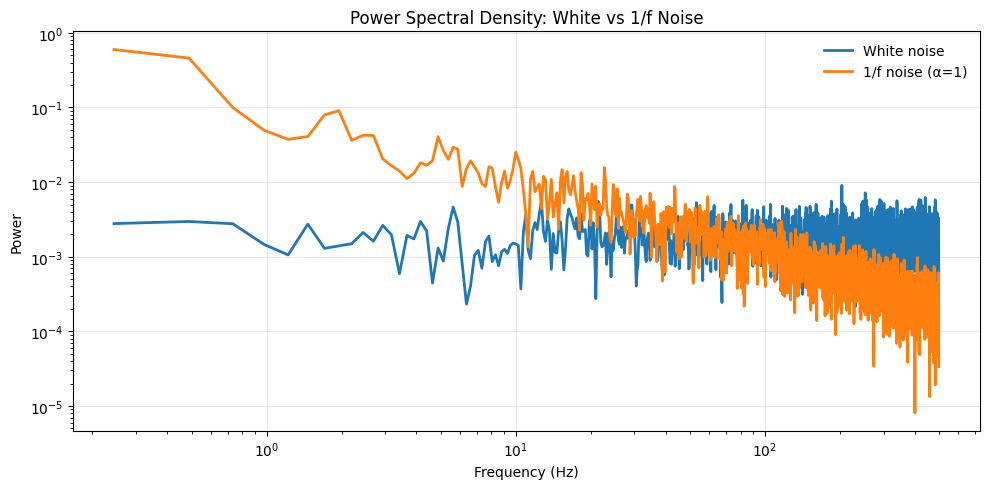

In [4]:
# =============================================================================
# Demonstrate PSD: White vs 1/f Noise
# Source: 1overf_sim.ipynb
# =============================================================================

n = 12000
fs = 1000.0

x_white = make_white_noise(n, seed=1)
x_pink = make_1_over_f_noise(n, fs=fs, alpha=1.0, seed=1)

# Compute PSDs
f_w, P_w = psd_welch(x_white, fs, nperseg=4096)
f_p, P_p = psd_welch(x_pink, fs, nperseg=4096)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.loglog(f_w[1:], P_w[1:], linewidth=2, label='White noise')
ax.loglog(f_p[1:], P_p[1:], linewidth=2, label='1/f noise (α=1)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')
ax.set_title('Power Spectral Density: White vs 1/f Noise')
ax.legend(frameon=False)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 3. Autocorrelation Function (ACF)

The autocorrelation function reveals temporal dependencies and memory in a signal.

**Sources**: [1overf_sim.ipynb](../1overf_sim.ipynb), [DeepLagAttention.ipynb](../DeepLagAttention.ipynb)

In [5]:
# =============================================================================
# Autocorrelation Function
# =============================================================================

# Variant 1: Full correlation-based ACF
# Source: 1overf_sim.ipynb
def autocorr(x, max_lag):
    """
    Compute normalized autocorrelation function.
    
    Parameters
    ----------
    x : np.ndarray
        1D time series.
    max_lag : int
        Maximum lag to compute.
    
    Returns
    -------
    np.ndarray
        Autocorrelation values from lag 0 to max_lag.
    """
    x = x - np.mean(x)
    ac = np.correlate(x, x, mode="full")
    ac = ac[ac.size // 2:]  # Keep positive lags
    ac0 = ac[0] if ac[0] != 0 else 1.0
    return (ac / ac0)[:max_lag + 1]


# Variant 2: Simplified ACF
# Source: 1overf_sim.ipynb (alternate version)
def autocorr_simple(x, L):
    """
    Compute autocorrelation up to lag L.
    
    Parameters
    ----------
    x : np.ndarray
        Input signal.
    L : int
        Maximum lag.
    
    Returns
    -------
    np.ndarray
        Autocorrelation values.
    """
    x = x - np.mean(x)
    c = np.correlate(x, x, mode="full")
    c = c[c.size//2:]
    return c[:L] / c[0]


print("ACF functions defined: autocorr(), autocorr_simple()")

ACF functions defined: autocorr(), autocorr_simple()


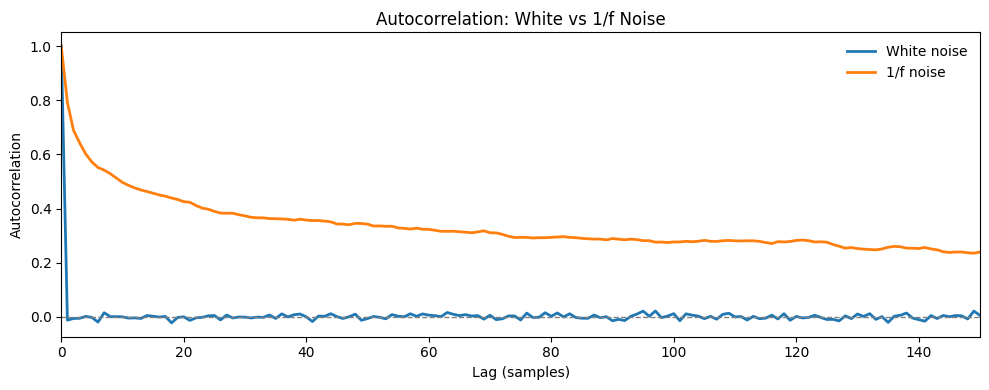

White noise: ACF drops to ~0 immediately (no memory)
1/f noise: ACF decays slowly (long-range dependence)


In [6]:
# =============================================================================
# Demonstrate ACF: White vs 1/f Noise
# Source: 1overf_sim.ipynb
# =============================================================================

max_lag = 150
ac_white = autocorr(x_white, max_lag)
ac_pink = autocorr(x_pink, max_lag)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ac_white, linewidth=2, label='White noise')
ax.plot(ac_pink, linewidth=2, label='1/f noise')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel('Lag (samples)')
ax.set_ylabel('Autocorrelation')
ax.set_title('Autocorrelation: White vs 1/f Noise')
ax.legend(frameon=False)
ax.set_xlim([0, max_lag])
plt.tight_layout()
plt.show()

print("White noise: ACF drops to ~0 immediately (no memory)")
print("1/f noise: ACF decays slowly (long-range dependence)")

---

## 4. Hilbert Transform & Envelope

The Hilbert transform provides the analytic signal, from which we extract the instantaneous amplitude (envelope) and phase.

**Sources**: [AdvatnagToSpectralMethod.ipynb](../AdvatnagToSpectralMethod.ipynb), [MiceData.ipynb](../MiceData.ipynb)

In [7]:
# =============================================================================
# Hilbert Transform & Envelope Extraction
# =============================================================================

# Variant 1: Custom NumPy implementation
# Source: AdvatnagToSpectralMethod.ipynb
def analytic_signal(x):
    """
    Compute analytic signal via Hilbert transform (NumPy only).
    
    The analytic signal is z = x + i*H{x}, where H{x} is the Hilbert transform.
    The envelope (instantaneous amplitude) is |z|.
    The instantaneous phase is angle(z).
    
    Parameters
    ----------
    x : np.ndarray
        Real input signal.
    
    Returns
    -------
    np.ndarray
        Complex analytic signal.
    """
    x = np.asarray(x)
    n = x.size
    X = np.fft.fft(x)
    h = np.zeros(n)
    if n % 2 == 0:
        h[0] = 1
        h[n//2] = 1
        h[1:n//2] = 2
    else:
        h[0] = 1
        h[1:(n+1)//2] = 2
    z = np.fft.ifft(X * h)
    return z


def envelope(x):
    """Extract instantaneous amplitude (envelope) from signal."""
    return np.abs(analytic_signal(x))


def instantaneous_phase(x):
    """Extract instantaneous phase from signal."""
    return np.angle(analytic_signal(x))


# Variant 2: Using scipy.signal.hilbert
# Source: MiceData.ipynb
from scipy.signal import hilbert as scipy_hilbert

def envelope_scipy(x):
    """Extract envelope using scipy's Hilbert transform."""
    return np.abs(scipy_hilbert(x))


print("Hilbert functions defined: analytic_signal(), envelope(), instantaneous_phase(), envelope_scipy()")

Hilbert functions defined: analytic_signal(), envelope(), instantaneous_phase(), envelope_scipy()


In [8]:
# =============================================================================
# Burst Duration Analysis from Envelope
# Source: AdvatnagToSpectralMethod.ipynb
# =============================================================================

def burst_durations(env, fs, thresh_quantile=0.85, min_ms=30):
    """
    Compute burst durations where envelope exceeds a threshold.
    
    Parameters
    ----------
    env : np.ndarray
        Envelope signal.
    fs : float
        Sampling frequency.
    thresh_quantile : float
        Quantile threshold for burst detection.
    min_ms : float
        Minimum burst duration in milliseconds.
    
    Returns
    -------
    durations : np.ndarray
        Array of burst durations in seconds.
    thr : float
        Threshold value used.
    """
    thr = np.quantile(env, thresh_quantile)
    above = env > thr
    
    # Find contiguous True segments
    durations = []
    i = 0
    n = len(above)
    min_len = int((min_ms/1000) * fs)
    
    while i < n:
        if above[i]:
            j = i
            while j < n and above[j]:
                j += 1
            if (j - i) >= min_len:
                durations.append((j - i) / fs)
            i = j
        else:
            i += 1
    
    return np.array(durations), thr


print("Burst analysis function defined: burst_durations()")

Burst analysis function defined: burst_durations()


---

## 5. AM vs Nearby Modes

Two signals can have **identical power spectra** but very different dynamics:
- **Nearby modes**: Two close sinusoids → beating pattern
- **Amplitude modulation (AM)**: Single carrier modulated by envelope

This demonstrates the **limits of spectral methods** for characterizing dynamics.

**Source**: [AdvatnagToSpectralMethod.ipynb](../AdvatnagToSpectralMethod.ipynb)

In [9]:
# =============================================================================
# AM vs Nearby Modes: Same Spectrum, Different Dynamics
# Source: AdvatnagToSpectralMethod.ipynb
# =============================================================================

fs_demo = 500
T_demo = 12
t_demo = np.arange(int(fs_demo * T_demo)) / fs_demo
rng_demo = np.random.default_rng(0)

# Nearby modes: Two close sinusoids (beating)
x_near = np.sin(2*np.pi*10*t_demo) + 0.9*np.sin(2*np.pi*13*t_demo)

# AM dynamics: Single carrier with amplitude modulation
# Carrier at 11.5 Hz, modulator at 1.5 Hz → sidebands at 10 and 13 Hz
x_am = (1 + 0.9*np.sin(2*np.pi*1.5*t_demo)) * np.sin(2*np.pi*11.5*t_demo)

# Add colored noise
noise_demo = colored_noise_1_f(len(t_demo), fs_demo, rng=rng_demo)
x_near_noisy = x_near + 0.8*noise_demo
x_am_noisy = x_am + 0.8*noise_demo

# Normalize
def zscore(x):
    return (x - x.mean()) / (x.std() + 1e-12)

x_near_noisy = zscore(x_near_noisy)
x_am_noisy = zscore(x_am_noisy)

# Compute PSDs
f_near, P_near = psd_welch(x_near_noisy, fs_demo)
f_am, P_am = psd_welch(x_am_noisy, fs_demo)

print("Signals generated: nearby modes vs AM dynamics")

Signals generated: nearby modes vs AM dynamics


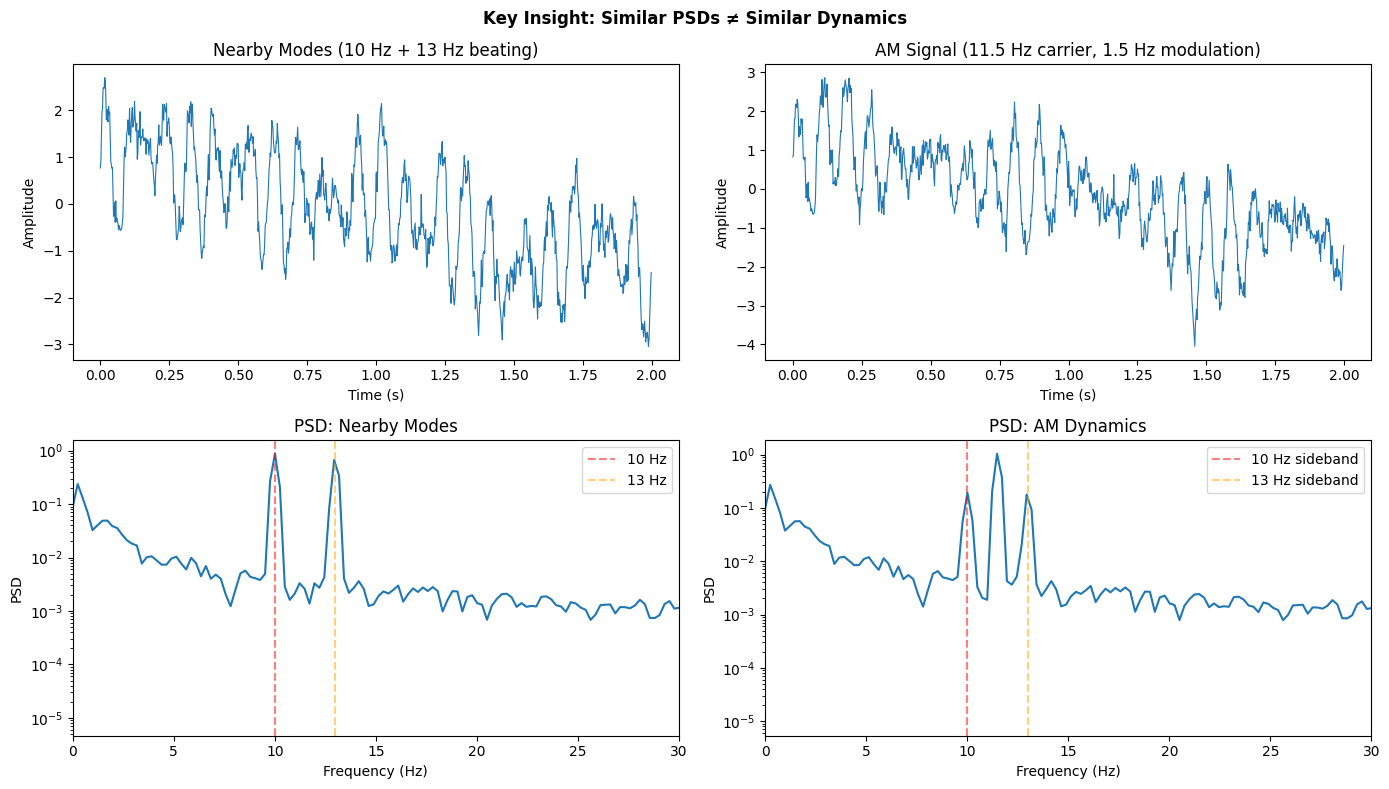

In [10]:
# Visualization: Similar PSDs but different dynamics
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Time series (short window)
tmax = 2.0
mask = t_demo < tmax

axes[0,0].plot(t_demo[mask], x_near_noisy[mask], lw=0.8)
axes[0,0].set_title("Nearby Modes (10 Hz + 13 Hz beating)")
axes[0,0].set_xlabel("Time (s)")
axes[0,0].set_ylabel("Amplitude")

axes[0,1].plot(t_demo[mask], x_am_noisy[mask], lw=0.8)
axes[0,1].set_title("AM Signal (11.5 Hz carrier, 1.5 Hz modulation)")
axes[0,1].set_xlabel("Time (s)")
axes[0,1].set_ylabel("Amplitude")

# PSDs
axes[1,0].semilogy(f_near, P_near, lw=1.5)
axes[1,0].set_xlim(0, 30)
axes[1,0].set_xlabel("Frequency (Hz)")
axes[1,0].set_ylabel("PSD")
axes[1,0].set_title("PSD: Nearby Modes")
axes[1,0].axvline(10, ls='--', c='red', alpha=0.5, label='10 Hz')
axes[1,0].axvline(13, ls='--', c='orange', alpha=0.5, label='13 Hz')
axes[1,0].legend()

axes[1,1].semilogy(f_am, P_am, lw=1.5)
axes[1,1].set_xlim(0, 30)
axes[1,1].set_xlabel("Frequency (Hz)")
axes[1,1].set_ylabel("PSD")
axes[1,1].set_title("PSD: AM Dynamics")
axes[1,1].axvline(10, ls='--', c='red', alpha=0.5, label='10 Hz sideband')
axes[1,1].axvline(13, ls='--', c='orange', alpha=0.5, label='13 Hz sideband')
axes[1,1].legend()

plt.suptitle("Key Insight: Similar PSDs ≠ Similar Dynamics", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 6. IAAFT Surrogates (Iterative Amplitude-Adjusted Fourier Transform)

**Source:** `AdvatnagToSpectralMethod.ipynb`

IAAFT surrogates preserve the power spectrum and amplitude distribution of a signal while randomizing phase relationships. Useful for:
- Testing for nonlinear structure
- Null hypothesis testing in spectral analysis
- Detecting phase-amplitude coupling

In [11]:
# =============================================================================
# IAAFT Surrogate Generation
# Source: AdvatnagToSpectralMethod.ipynb
# =============================================================================

def iaaft_surrogate(
    x: np.ndarray,
    n_iter: int = 100,
    rng: np.random.Generator | None = None
) -> np.ndarray:
    """
    Iterative Amplitude-Adjusted Fourier Transform surrogate.
    
    Preserves:
    - Power spectrum (approximately)
    - Amplitude distribution (exactly)
    
    Destroys:
    - Phase correlations / nonlinear structure
    
    Parameters
    ----------
    x : np.ndarray
        Input signal
    n_iter : int
        Number of iterations (typically 10-100)
    rng : Generator
        Random number generator for reproducibility
        
    Returns
    -------
    np.ndarray
        Surrogate time series
    """
    if rng is None:
        rng = np.random.default_rng()
    
    n = len(x)
    x_sorted = np.sort(x)
    
    # Target spectrum from original signal
    X_target = np.fft.rfft(x)
    amp_target = np.abs(X_target)
    
    # Initialize with shuffled version
    idx = rng.permutation(n)
    s = x[idx].copy()
    
    for _ in range(n_iter):
        # FFT and impose target amplitude spectrum
        S = np.fft.rfft(s)
        S_new = amp_target * np.exp(1j * np.angle(S))
        s = np.fft.irfft(S_new, n=n)
        
        # Rank-order to match original amplitude distribution
        ranks = np.argsort(np.argsort(s))
        s = x_sorted[ranks]
    
    return s


# Alternative: Simple Fourier surrogate (faster, less accurate)
def fourier_surrogate(
    x: np.ndarray,
    rng: np.random.Generator | None = None
) -> np.ndarray:
    """
    Simple Fourier surrogate with randomized phases.
    
    Preserves power spectrum exactly, but amplitude distribution only approximately.
    """
    if rng is None:
        rng = np.random.default_rng()
    
    X = np.fft.rfft(x)
    random_phases = rng.uniform(0, 2*np.pi, len(X))
    random_phases[0] = 0  # Keep DC component real
    if len(x) % 2 == 0:
        random_phases[-1] = 0  # Keep Nyquist real for even-length
    
    X_surrogate = np.abs(X) * np.exp(1j * random_phases)
    return np.fft.irfft(X_surrogate, n=len(x))


print("IAAFT and Fourier surrogate functions defined")

IAAFT and Fourier surrogate functions defined


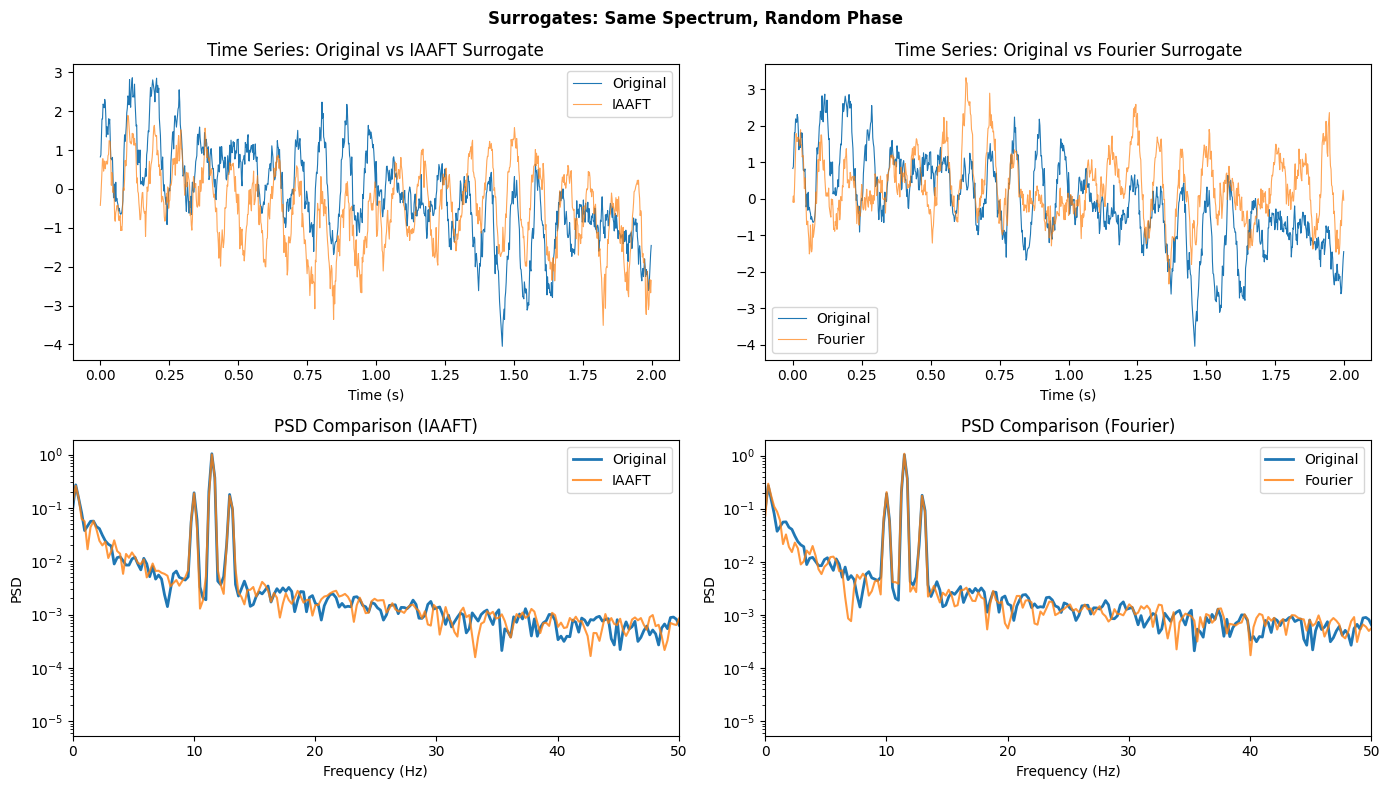

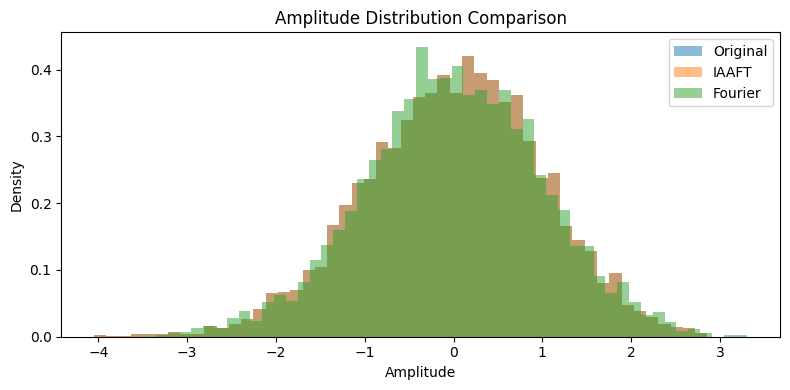

In [12]:
# Demo: IAAFT surrogate preserves spectrum, destroys phase structure
rng_surr = np.random.default_rng(42)

# Use the AM signal which has phase coupling
x_original = x_am_noisy.copy()
x_iaaft = iaaft_surrogate(x_original, n_iter=50, rng=rng_surr)
x_fourier = fourier_surrogate(x_original, rng=rng_surr)

# Compare PSDs
f_orig, P_orig = psd_welch(x_original, fs_demo)
f_iaaft, P_iaaft = psd_welch(x_iaaft, fs_demo)
f_four, P_four = psd_welch(x_fourier, fs_demo)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Time series
axes[0,0].plot(t_demo[:1000], x_original[:1000], lw=0.8, label='Original')
axes[0,0].plot(t_demo[:1000], x_iaaft[:1000], lw=0.8, alpha=0.7, label='IAAFT')
axes[0,0].set_title("Time Series: Original vs IAAFT Surrogate")
axes[0,0].set_xlabel("Time (s)")
axes[0,0].legend()

axes[0,1].plot(t_demo[:1000], x_original[:1000], lw=0.8, label='Original')
axes[0,1].plot(t_demo[:1000], x_fourier[:1000], lw=0.8, alpha=0.7, label='Fourier')
axes[0,1].set_title("Time Series: Original vs Fourier Surrogate")
axes[0,1].set_xlabel("Time (s)")
axes[0,1].legend()

# PSDs
axes[1,0].semilogy(f_orig, P_orig, lw=2, label='Original')
axes[1,0].semilogy(f_iaaft, P_iaaft, lw=1.5, alpha=0.8, label='IAAFT')
axes[1,0].set_xlim(0, 50)
axes[1,0].set_xlabel("Frequency (Hz)")
axes[1,0].set_ylabel("PSD")
axes[1,0].set_title("PSD Comparison (IAAFT)")
axes[1,0].legend()

axes[1,1].semilogy(f_orig, P_orig, lw=2, label='Original')
axes[1,1].semilogy(f_four, P_four, lw=1.5, alpha=0.8, label='Fourier')
axes[1,1].set_xlim(0, 50)
axes[1,1].set_xlabel("Frequency (Hz)")
axes[1,1].set_ylabel("PSD")
axes[1,1].set_title("PSD Comparison (Fourier)")
axes[1,1].legend()

plt.suptitle("Surrogates: Same Spectrum, Random Phase", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Amplitude distribution comparison
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 4))
ax2.hist(x_original, bins=50, alpha=0.5, density=True, label='Original')
ax2.hist(x_iaaft, bins=50, alpha=0.5, density=True, label='IAAFT')
ax2.hist(x_fourier, bins=50, alpha=0.5, density=True, label='Fourier')
ax2.set_xlabel("Amplitude")
ax2.set_ylabel("Density")
ax2.set_title("Amplitude Distribution Comparison")
ax2.legend()
plt.tight_layout()
plt.show()

---

## 7. Bicoherence (Higher-Order Spectral Analysis)

**Source:** `AdvatnagToSpectralMethod.ipynb`

Bicoherence detects quadratic phase coupling between frequency components. Values near 1 indicate strong phase-locking between f1, f2, and f1+f2.

$$
b(f_1, f_2) = \frac{|E[X(f_1) X(f_2) X^*(f_1+f_2)]|^2}{E[|X(f_1) X(f_2)|^2] E[|X(f_1+f_2)|^2]}
$$

Applications:
- Detecting nonlinear coupling in neural oscillations
- Cross-frequency coupling (phase-amplitude coupling)
- Distinguishing AM from independent oscillations

In [13]:
# =============================================================================
# Bicoherence Computation
# Source: AdvatnagToSpectralMethod.ipynb
# =============================================================================

def bicoherence_map(
    x: np.ndarray,
    fs: float,
    nperseg: int = 256,
    noverlap: int | None = None,
    fmax: float | None = None
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute bicoherence map via segment averaging.
    
    Parameters
    ----------
    x : np.ndarray
        Input signal
    fs : float
        Sampling frequency
    nperseg : int
        Segment length for FFT
    noverlap : int
        Overlap between segments
    fmax : float
        Maximum frequency to compute (reduces computation)
        
    Returns
    -------
    f : np.ndarray
        Frequency axis
    bic : np.ndarray
        Bicoherence matrix (f1 x f2)
    """
    if noverlap is None:
        noverlap = nperseg // 2
    if fmax is None:
        fmax = fs / 4  # Default to quarter Nyquist
    
    # Segment signal
    step = nperseg - noverlap
    n_seg = (len(x) - nperseg) // step + 1
    
    # Frequency resolution
    freqs = np.fft.rfftfreq(nperseg, 1/fs)
    mask = freqs <= fmax
    freqs_out = freqs[mask]
    nf = len(freqs_out)
    
    # Accumulators
    bispectrum = np.zeros((nf, nf), dtype=complex)
    norm1 = np.zeros((nf, nf))
    norm2 = np.zeros((nf, nf))
    
    for i in range(n_seg):
        seg = x[i*step : i*step + nperseg]
        seg = seg - seg.mean()
        seg = seg * np.hanning(nperseg)
        
        X = np.fft.rfft(seg)
        X_trunc = X[:nf]
        
        for i1 in range(nf):
            for i2 in range(i1, nf):
                i3 = i1 + i2
                if i3 < len(X):
                    prod = X_trunc[i1] * X_trunc[i2] * np.conj(X[i3])
                    bispectrum[i1, i2] += prod
                    norm1[i1, i2] += np.abs(X_trunc[i1] * X_trunc[i2])**2
                    norm2[i1, i2] += np.abs(X[i3])**2
    
    # Compute bicoherence (avoid divide by zero)
    with np.errstate(divide='ignore', invalid='ignore'):
        bic = np.abs(bispectrum)**2 / (norm1 * norm2 + 1e-12)
    
    # Mirror to lower triangle for visualization
    bic = bic + bic.T - np.diag(np.diag(bic))
    
    return freqs_out, bic


print("Bicoherence function defined")

Bicoherence function defined


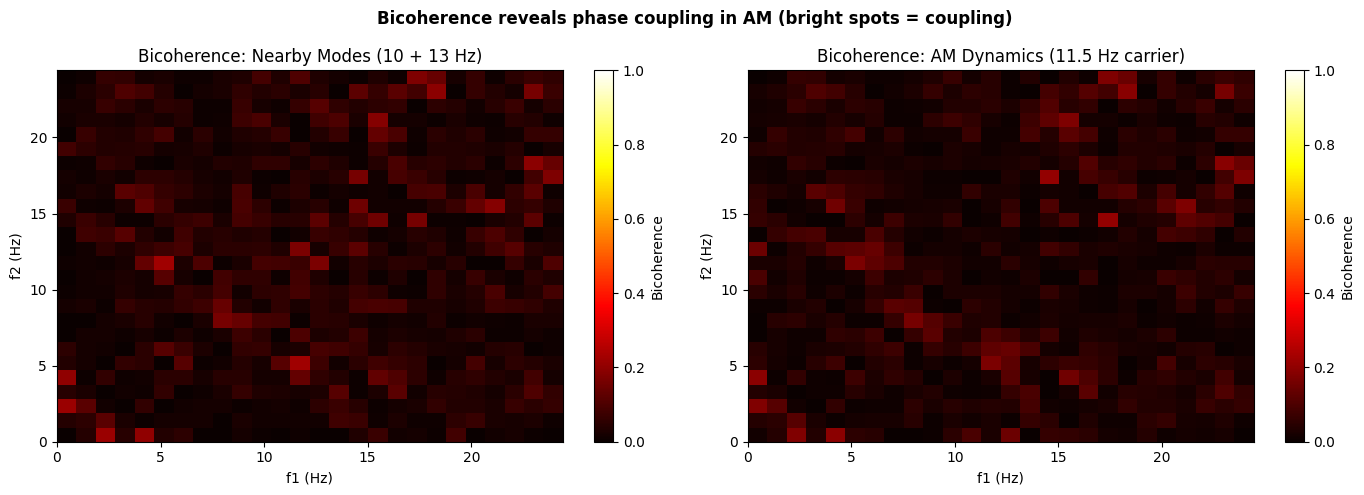

In [14]:
# Demo: Bicoherence for AM vs Nearby Modes
# AM signal should show high bicoherence at (1.5, 10) and (1.5, 13) due to carrier-sideband coupling

# Compute bicoherence for both signals
f_bic_near, bic_near = bicoherence_map(x_near_noisy, fs_demo, nperseg=512, fmax=25)
f_bic_am, bic_am = bicoherence_map(x_am_noisy, fs_demo, nperseg=512, fmax=25)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im0 = axes[0].imshow(bic_near, origin='lower', aspect='auto', 
                      extent=[f_bic_near[0], f_bic_near[-1], f_bic_near[0], f_bic_near[-1]],
                      cmap='hot', vmin=0, vmax=1)
axes[0].set_xlabel("f1 (Hz)")
axes[0].set_ylabel("f2 (Hz)")
axes[0].set_title("Bicoherence: Nearby Modes (10 + 13 Hz)")
plt.colorbar(im0, ax=axes[0], label='Bicoherence')

im1 = axes[1].imshow(bic_am, origin='lower', aspect='auto', 
                      extent=[f_bic_am[0], f_bic_am[-1], f_bic_am[0], f_bic_am[-1]],
                      cmap='hot', vmin=0, vmax=1)
axes[1].set_xlabel("f1 (Hz)")
axes[1].set_ylabel("f2 (Hz)")
axes[1].set_title("Bicoherence: AM Dynamics (11.5 Hz carrier)")
plt.colorbar(im1, ax=axes[1], label='Bicoherence')

plt.suptitle("Bicoherence reveals phase coupling in AM (bright spots = coupling)", 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 8. Spectrogram (Time-Frequency Analysis)

**Sources:** `MiceData.ipynb`, `scipy.signal`

Spectrograms visualize how the frequency content of a signal evolves over time. Useful for:
- Detecting transient oscillatory events (ripples, spindles)
- Tracking frequency modulation
- Visualizing non-stationary dynamics

In [15]:
# =============================================================================
# Spectrogram and Bandpass Filtering
# Source: MiceData.ipynb, scipy.signal
# =============================================================================
from scipy.signal import spectrogram as scipy_spectrogram
from scipy.ndimage import gaussian_filter

def bandpass_filter(
    data: np.ndarray,
    lowcut: float,
    highcut: float,
    fs: float,
    order: int = 4
) -> np.ndarray:
    """
    Butterworth bandpass filter.
    
    Parameters
    ----------
    data : np.ndarray
        Input signal
    lowcut : float
        Low cutoff frequency (Hz)
    highcut : float
        High cutoff frequency (Hz)
    fs : float
        Sampling frequency
    order : int
        Filter order
        
    Returns
    -------
    np.ndarray
        Filtered signal
    """
    from scipy.signal import butter, filtfilt
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


def compute_spectrogram(
    x: np.ndarray,
    fs: float,
    nperseg: int = 256,
    noverlap: int | None = None,
    smooth_sigma: float | None = None
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute spectrogram with optional Gaussian smoothing.
    
    Parameters
    ----------
    x : np.ndarray
        Input signal
    fs : float
        Sampling frequency
    nperseg : int
        Segment length for STFT
    noverlap : int
        Overlap between segments
    smooth_sigma : float
        Gaussian smoothing sigma (None = no smoothing)
        
    Returns
    -------
    f : np.ndarray
        Frequency axis
    t : np.ndarray
        Time axis
    Sxx : np.ndarray
        Power spectral density (f x t)
    """
    if noverlap is None:
        noverlap = nperseg // 2
    
    f, t, Sxx = scipy_spectrogram(x, fs, nperseg=nperseg, noverlap=noverlap)
    
    if smooth_sigma is not None:
        Sxx = gaussian_filter(Sxx, sigma=smooth_sigma)
    
    return f, t, Sxx


print("Spectrogram and bandpass filter functions defined")

Spectrogram and bandpass filter functions defined


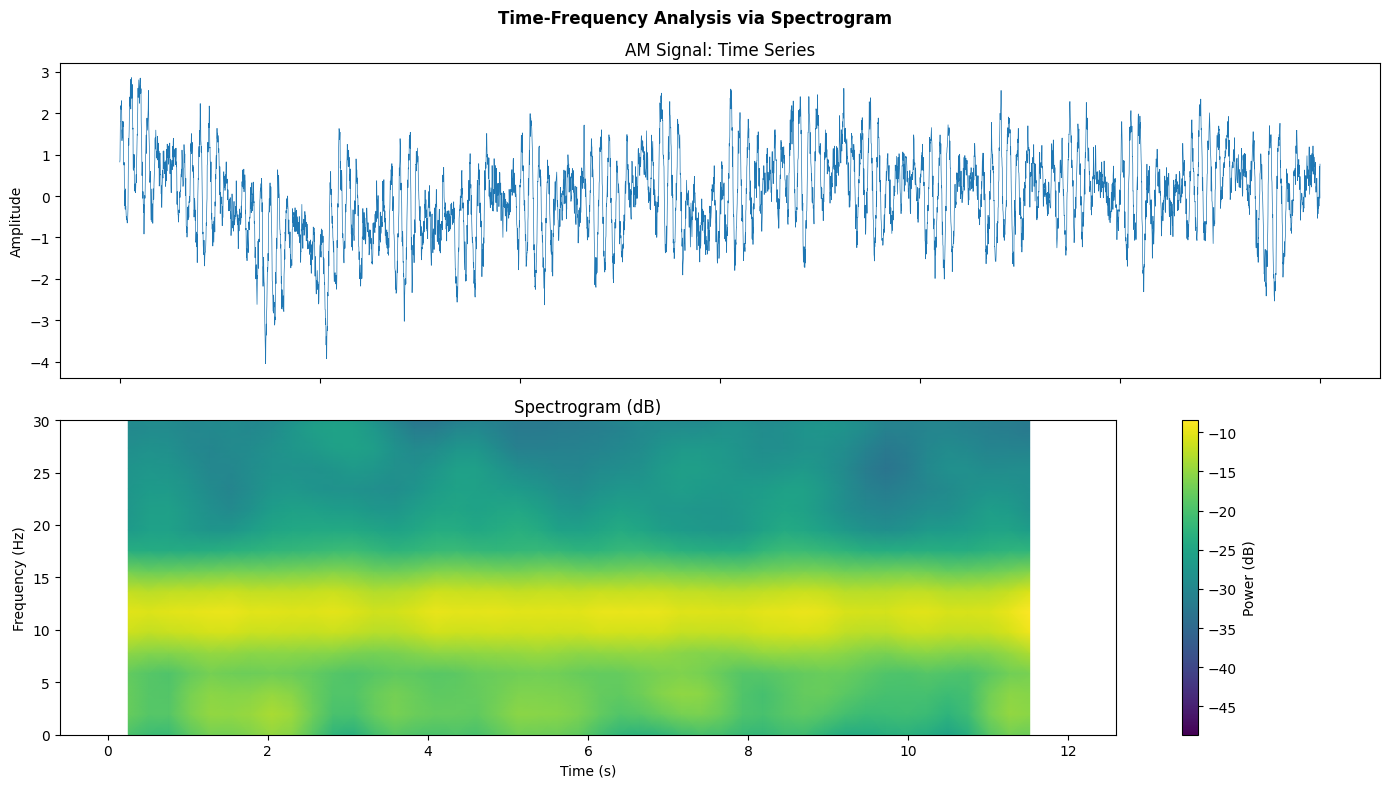

In [16]:
# Demo: Spectrogram of AM signal showing time-varying frequency content
f_spec, t_spec, Sxx = compute_spectrogram(x_am_noisy, fs_demo, nperseg=256, smooth_sigma=1)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Time series
axes[0].plot(t_demo, x_am_noisy, lw=0.5)
axes[0].set_ylabel("Amplitude")
axes[0].set_title("AM Signal: Time Series")

# Spectrogram
im = axes[1].pcolormesh(t_spec, f_spec, 10*np.log10(Sxx + 1e-12), 
                         shading='gouraud', cmap='viridis')
axes[1].set_ylabel("Frequency (Hz)")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylim(0, 30)
axes[1].set_title("Spectrogram (dB)")
plt.colorbar(im, ax=axes[1], label='Power (dB)')

plt.suptitle("Time-Frequency Analysis via Spectrogram", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

## Summary: Functions Collected

This notebook consolidates spectral and correlation analysis functions from across the repository:

| Function | Purpose | Source |
|----------|---------|--------|
| `make_white_noise` | Gaussian white noise | `1overf_sim.ipynb` |
| `make_1_over_f_noise` | 1/f^α colored noise | `1overf_sim.ipynb` |
| `colored_noise_1_f` | Colored noise (alternate) | `AdvatnagToSpectralMethod.ipynb` |
| `psd_welch` | PSD via scipy Welch | `1overf_sim.ipynb` |
| `welch_psd_custom` | Custom Welch implementation | `AdvatnagToSpectralMethod.ipynb` |
| `autocorr` | Full autocorrelation | `1overf_sim.ipynb` |
| `autocorr_simple` | Simple ACF | `AdvatnagToSpectralMethod.ipynb` |
| `analytic_signal` | Hilbert transform (NumPy) | `AdvatnagToSpectralMethod.ipynb` |
| `envelope` | Envelope extraction | `AdvatnagToSpectralMethod.ipynb` |
| `instantaneous_phase` | Phase from analytic signal | `AdvatnagToSpectralMethod.ipynb` |
| `envelope_scipy` | Envelope via scipy | `MiceData.ipynb` |
| `burst_durations` | Detect burst events | `AdvatnagToSpectralMethod.ipynb` |
| `iaaft_surrogate` | IAAFT surrogates | `AdvatnagToSpectralMethod.ipynb` |
| `fourier_surrogate` | Simple phase-randomized surrogate | New |
| `bicoherence_map` | Higher-order spectral analysis | `AdvatnagToSpectralMethod.ipynb` |
| `bandpass_filter` | Butterworth bandpass | `MiceData.ipynb` |
| `compute_spectrogram` | STFT spectrogram | `MiceData.ipynb` |

### Key Concepts Demonstrated

1. **Same spectrum ≠ same dynamics** (AM vs nearby modes)
2. **Surrogates preserve spectrum while destroying phase structure**
3. **Bicoherence detects quadratic phase coupling**
4. **Spectrograms reveal time-varying frequency content**